# تمرین کامپیوتری سوم - Naive Bayes Classifier
#  نیما مدیرکیاسرایی 810198471

## هدف بازی 
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir"  size=3>
در این تمرین کامپیوتری با استفاده از Naive Bayes Classifier و با استفاده از اطلاعات موجود در فایل train مدلی درست می کنیم تا بتوانیم با در نظر گرفتن محتوای هر خبر در فایل test تیتر آن خبر را پیش بینی کنیم.
</font>
</p>


## فاز اول : پیش پردازش داده
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
در فاز اول باید اطلاعات متنی داخل مجموعه داده را برای تحلیلهای بعدی پیش پردازش کنیم. در این قسمت می توانیم از کتابخانه های hazm و parsivar استفاده کنیم که با تست کردن متدهای مختلف این دو کتابخانه ، تصمیم گرفتم تا فقط از کتابخانه hazm استفاده کنم تا پیش پردازش بهتری روی مجموعه داده انجام شود.
در این قسمت از متد های Normalizer و Lemmatizer و word_tokenize از کتابخانه hazm استفاده می کنیم. متد Normalizer کمک به normalize کردن متن های ما می کند به عنوان مثال کلمه هایی که درون آن ها فاصله یا نیم فاصله دارد آن دو بخش را از هم جدا می کند و اگر خروجی آن را به متد Lemmatizer بدهیم می توانیم کلمه اصلی را از آن بیرون بکشیم. همچنین متد word_tokenize به عنوان ورودی یک متن می گیرد و در خروجی یک لیست را برمی گرداند که درون آن کلمه های جدا شده(tokens) متن ورودی می باشد.
قطعه کد زیر مثالی برای استفاده از دو متد اول است.
</font>
</p>

In [1]:
import pandas as pd
import hazm
from matplotlib import pyplot as plt
import math

In [2]:
hazm_normalizer = hazm.Normalizer()
hazm_lemmatizer = hazm.Lemmatizer()
hazm_stemmer = hazm.Stemmer()

In [3]:
hazm_normalizer.normalize('گزارش ها')

'گزارش\u200cها'

In [4]:
hazm_lemmatizer.lemmatize('گزارش\u200cها')

'گزارش'

In [5]:
hazm_stemmer.stem('رفتم')

'رف'

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
همانطور که در قسمت بالا می بینیم در بعضی موارد متد stem به درستی کار نمی کند بنابراین تصمیم گرفتم از آن استفاده نکنم و فقط از Lemmatizer استفاده کنم.
در پیش پردازش داده ها علاوه بر استفاده از این متد ها لیست هایی به اسم stop_punctuations و stop_words داریم که لغات و علامت هایی که نیاز داریم در این فاز از متن ها حذف شوند در آنها حضور دارند. همچنین تمامی عدد ها در متن ها را نیز حذف می کنیم چون در پیش بینی ما تاثیر خاصی ندارند.
    
1) متد stemming ریشه کلمات را در می آورد به عنوان مثال اگر به ورودی آن کلمه "خوردم" را بدهیم ، در خروجی کلمه "خورد" را بر می گرداند.
متد Lemmatizing کلمات مشابه مثل هم خانواده ها را یک کلمه در نظر می گیرد و به عنوان خروجی تحویل می دهد.
</font>
</p>

In [6]:
train = pd.read_csv('Dataset/train.csv')

In [7]:
test = pd.read_csv('Dataset/test.csv')

In [8]:
def preprocess(df):
    stop_words = set(hazm.stopwords_list())
    stop_words.add('توانست')
    stop_words.add('هست')
    stop_words.add('کاهش')
    stop_punctuations = set('''!()-[]{};:'"\,٬٫،<>./?@#$%٪^&*×ـ+=_~.؟؛«»|…''')
    ### Normalizing ###
    for col in df:
        for cell in range(len(df)):
            df[col][cell] = hazm_normalizer.normalize(df[col][cell])
            
    ### Tokenizing ###
    for cell in range(len(df)):
        df['content'][cell] = hazm.word_tokenize(df['content'][cell])
    
    ### Lemmatizing ###
    for cell in range(len(df)):
        temp = []
        for word in df['content'][cell]:
            word = hazm_lemmatizer.lemmatize(word).split('#')
            if (len(word) == 1) :
                word = word[0]
            else:
                if (word[0] != '') :
                    word = word[0]
                else :
                    word = word[1]
            if (word not in stop_words) and (word not in stop_punctuations) and (word.isdigit() == False):
                temp.append(word)
        df['content'][cell] = temp
    return df

In [9]:
train_preprocessed = preprocess(train)

In [10]:
test_preprocessed = preprocess(test)

## فاز دوم : فرآیند مسئله
<div align=center><img src='bayes.png'/></div><br/>

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
در رابطه بالا x در واقع همان کلمه دیده شده در یک متن خبر(در حالت bigram می تواند مجموعه ای از کلمات پشت هم باشد) و c تیتر همان خبر است.
    
2)    
Posterior همان P(c|x) می باشد که به معنی روبه رو است : احتمال اینکه تیتر خبر c باشد به شرط اینکه کلمه x در آن دیده شود. برای حساب کردن این احتمال می توانیم از دو رابطه استفاده کنیم که در عکس بالا آورده شده است.(در این مساله از رابطه دوم برای محاسبه این احتمال استفاده می کنیم.)
    
Liklelihood همان P(x|c) می باشد که به معنی رو به رو است : احتمال اینکه کلمه x در یک خبر دیده شود به شرط اینکه تیتر آن خبر c باشد. برای محاسبه این احتمال ، به طور کلی می توانیم کل کلمات و تعداد بار های تکرار آن ها در تمامی خبرهای با تیتر c را داشته باشیم و برای محاسبه ، تعداد تکرار کلمه x را تقسیم بر تعداد تکرار کل کلمات در خبرهایی با تیتر c می کنیم.
    
Prior همان P(c) می باشد که به معنی رو به رو است : احتمال اینکه تیتر خبر c باشد. در این مساله چون به تعداد مساوی خبر از هر تیتر داریم و کلا 6 تیتر داریم پس این احتمال برابر است با 1/6.
    
Evidence همان P(x) می باشد که به معنی رو به رو است : احتمال اینکه کلمه x را ببینیم. در واقع در این مساله برای محسابه آن باید احتمال وجود کلمه x در تمام متن های خبری با هر کدام از تیتر ها را با هم جمع کنیم.
</font>
</p>

In [11]:
words = dict()
for label in train_preprocessed['label'].unique():
    words[label] = dict()
for row in range(len(train_preprocessed)):
    for word in train_preprocessed['content'][row]:
        if word in words[train_preprocessed['label'][row]]:
            words[train_preprocessed['label'][row]][word] += 1
        else:
            words[train_preprocessed['label'][row]][word] = 1

In [12]:
def categorise(df, dummy_labels):
    for i in range(len(df['label'])):
        df['dummy'][i] = dummy_labels[df['label'][i]]
    return df

In [13]:
train_preprocessed['dummy'] = 1
test_preprocessed['dummy'] = 1

labels = train_preprocessed['label'].unique()
dummy_labels ={}
for i in range(len(labels)):
    dummy_labels[labels[i]] = i

train_preprocessed = categorise(train_preprocessed, dummy_labels)
test_preprocessed = categorise(test_preprocessed, dummy_labels)

C:\Users\USER\AppData\Local\Temp\ipykernel_20664\2348710085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dummy'][i] = dummy_labels[df['label'][i]]


In [30]:
test_preprocessed

,label,content,dummy
0,فناوری,"[اعلام, لیس, شرکت, مجاز, ثبت, سفارش, ارائه, خد...",0
1,فرهنگی/هنری,"[استاد, علم, قرائت, قرآن, کریم, ریشه, موسیقی, ...",5
2,حوادث,"[آتش, سوزی‌های, زنجیره, جنگل, زاگرس, استان, ای...",2
3,فناوری,"[استفاده, سرویس‌های, iMassage, Facetime, محصول...",0
4,حوادث,"[دادستان, عموم, انقلاب, یاسوج, میلیون, دلار, ج...",2
...,...,...,...
1110,ورزشی,"[عضو, هیات, مدیره, باشگاه, استقلال, هیچوقت, دن...",1
1111,حوادث,"[مدیر, آموزش, پرورش, شهرستان, جیرفت, دستگیر, د...",2
1112,سیاسی,"[رییس, جمهور, هفته, گذشته, شهر, قرمزی, کشور, ا...",4
1113,فناوری,"[دارندگان, مدل‌های, اعلام‌شده, گوشی‌های, هوآوی...",0


In [15]:
train_preprocessed

,label,content,dummy
0,فناوری,"[گزارش, منتشر, حاکی, کاربر, تلگرام, مناطق, جها...",0
1,ورزشی,"[سوپر, استار, سینما, قهرمان, سابق, ووشو, کونگ‌...",1
2,حوادث,"[مدیرعامل, شرکت, عمران, آب, کیش, فوت, نفر, آتش...",2
3,فناوری,"[نوجوان, انگلیسی, اتهام, هک, حساب, کاربر, ایمی...",0
4,سلامت,"[دانشمند, مطالعات, اثرات, ویروس, کرونا, گوش, ک...",3
...,...,...,...
8995,حوادث,"[شانزدهم, مهر, امسال, درپی, تماس, مرکز, فوریت,...",2
8996,ورزشی,"[اتحادیه, فوتبال, ترینیداد, توباگو, اعلام, تیم...",1
8997,فرهنگی/هنری,"[اسامی, فیلم, مسابقه, مستند, ششمین, دوره, جشنو...",5
8998,حوادث,"[کامیونت, حامل, تخته, چوب, عصر, دیروز, چهارشنب...",2


In [16]:
number_words_inclass = []
for label in words.keys():
    number_words_inclass.append(sum(words[label].values())) 
number_words_inclass

[333495, 215608, 173708, 397602, 350040, 315394]

In [17]:
probability_of_words = []
for i in range(len(words.keys())):
    temp = words[list(words.keys())[i]].copy()
    for key in temp.keys():
        temp[key] =temp[key]/number_words_inclass[i]
    probability_of_words.append(temp)

In [18]:
test_labels = test_preprocessed['dummy'].tolist()
test_contents = test_preprocessed['content'].tolist()

In [19]:
def predictor_without_smoothing(test_content, prob_of_words_oneclass):
    prob = 1/6
    prob_of_words = []
    for i in range(len(test_content)):
        word = test_content[i]
        if(word in prob_of_words_oneclass):
            prob_of_words.append(math.log(prob_of_words_oneclass[word]))
    prob = prob * sum(prob_of_words)
    return prob

In [20]:
predicted_without_smoothing = []
for i in range(len(test_contents)):
    prob_of_content_in_classes = []
    for j in range(len(probability_of_words)):
        temp = predictor_without_smoothing(test_contents[i],probability_of_words[j])         
        prob_of_content_in_classes.append(temp)
    predicted_without_smoothing.append(prob_of_content_in_classes.index(max(prob_of_content_in_classes)))

In [21]:
def predictor_with_smoothing(test_feature, prob_of_words_oneclass, number_words_inclass):
    prob = 1/6
    prob_of_words = []
    count = 0
    alpha = 1
    for i in range(len(test_feature)):
        word = test_feature[i]
        if(word in prob_of_words_oneclass):
            prob_of_words.append(math.log(prob_of_words_oneclass[word]))
        else:
            count += 1
    for i in range(count):
        prob_of_words.append(math.log(alpha/(number_words_inclass + alpha*len(prob_of_words_oneclass.keys()))))
    prob = prob * sum(prob_of_words)
    return prob

In [22]:
predicted_with_smoothing = []
for i in range(len(test_contents)):
    prob_of_content_in_classes = []
    for j in range(len(probability_of_words)):
        temp = predictor_with_smoothing(test_contents[i],probability_of_words[j], number_words_inclass[j])                      
        prob_of_content_in_classes.append(temp)
    predicted_with_smoothing.append(prob_of_content_in_classes.index(max(prob_of_content_in_classes)))

## Bigrams  
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
3) اگر دو عبارت "شانه بدن" و "شانه سر" را در نظر بگیریم کلمه شانه در هر دو یکسان است اما دو معنی متفاوت می دهد. در واقع در این مثال با استفاده از bigram ها که ترکیب کلمه شانه با کلمه دوم است ، توانستیم معنی شانه را بفهمیم. در این مثال نیازی به n-gram طولانی تری نداریم و استفاده از bigram ها کافی است. ولی اگر 3 عبارت "شیر فلکه" و "شیر جنگل" و "شیر پاکتی" را در نظر بگیریم نیاز به 3-gram داریم تا معنی کلمه شیر را متوجه شویم.
</font>
</p>

## Additive Smoothing 
<div align=center><img src='bayes.png'/></div><br/>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
4) با توجه به فرمول بالا وقتی کلمه x در خبر با تیتر c دیده نشود احتمال P(x|c) صفر می شود بنابراین احتمال P(c|x) نیز صفر خواهد شد و مدل تشخیص می دهد که تیتر خبر قطعا c نخواهد بود در صورتی که احتمال زیادی وجود دارد که این حرف غلط باشد. در واقع اگر مثلا کلمه x فقط در خبرهایی با یک تیتر مشخص c آمده باشد ، مدل ما هر جا که کلمه x را ببیند با قاطعیت تشخیص می دهد که تیتر خبر c است در صورتی که نباید این طور باشد و برای رفع این مشکل از Additive Smoothing استفاده می کنیم.
</font>
</p>
5) <div align=center><img src='smoothing.png'/></div><br/>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
برای اینکه از Additive Smoothing در این مساله حساب کنیم ، بجای اینکه احتمال حضور کلمات در هر کلاس را با روش ساده قبلی حساب کنیم ، از فرمول بالا برای بدست آوردن این احتمال استفاده میکنیم. در این رابطه آلفا پارامتر Smoothing و d تعداد کلمه های یونیک در هر کلاس و N تعداد کل تکرار کلمات در هر کلاس و xi تعداد تکرار یک کلمه مشخص در یک کلاس می باشد.
    
با کمک گرفتن از این روش مشکل گفته شده در بالا (احتمال صفر برای حضور نداشتن یک کلمه در یک کلاس) حل می شود و برای تمامی کلمه ها یک احتمال غیر صفر در نظر می گیریم و به دقیق تر شدن نتایج ما خیلی کمک می کند که در ادامه خواهیم دید.
</font>
</p>

## بررسی صحت

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
6)
</font>
</p>

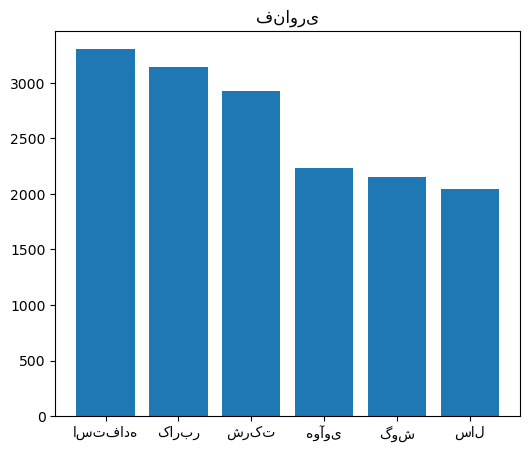

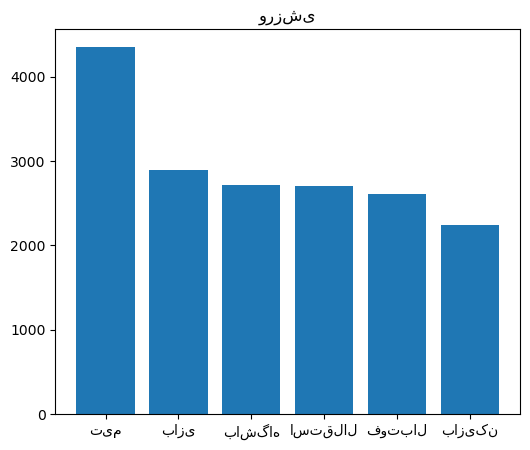

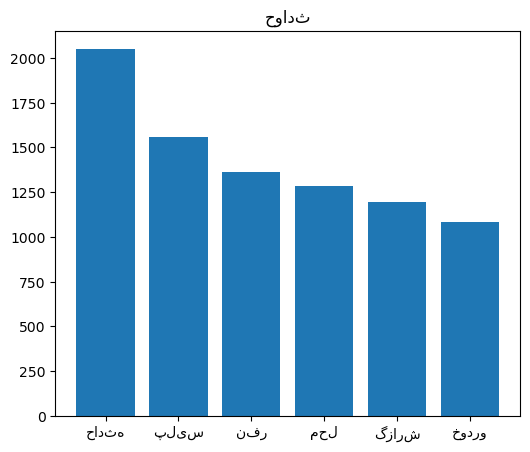

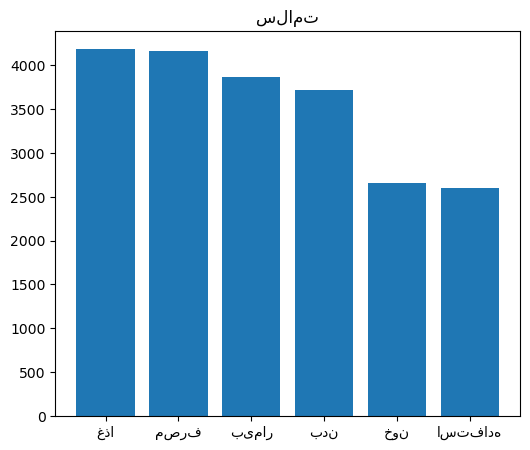

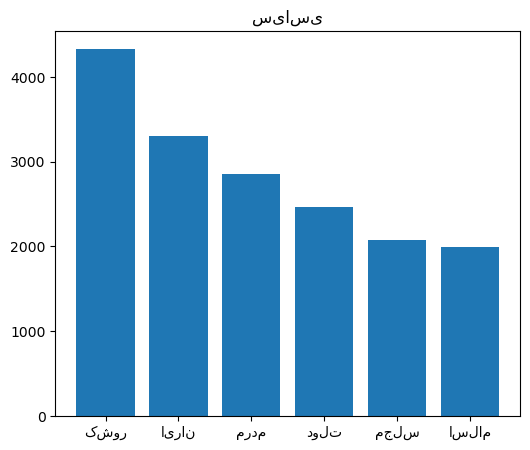

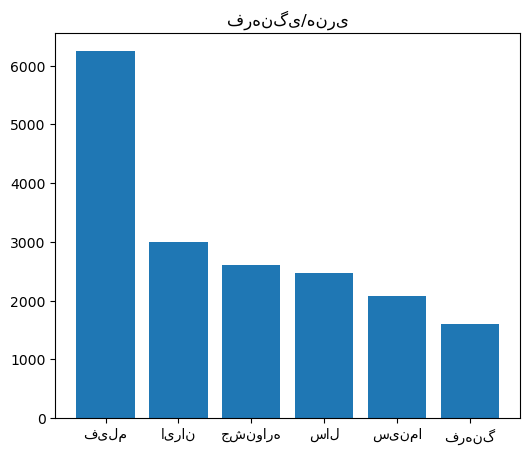

In [23]:
for title in words.keys():
    sorted_words = dict(sorted(words[title].items(), key=lambda x: x[1], reverse=True)[:6])
    plt.figure(figsize=(6,5))
    plt.bar(sorted_words.keys(), sorted_words.values())
    plt.title(title)
    plt.show()

## فاز دوم : ارزیابی
<div align=center><img src='evaluation.png'/></div><br/>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
7) همانطور که در شکل بالا می بینیم رابطه Precision اهمیتی به False Negative ها نمی دهد. یعنی در این مساله به تعداد خبرهایی که یک تیتری داشته اند ولی ما تیتر آنها را اشتباه تشخیص داده ایم اهمیتی نمی دهد. به عنوان مثال اگر در کل 50 تا خبر با تیتر فناوری داشته باشیم و مدل ما فقط تیتر یکی از این خبرها را به درستی فناوری پیش بینی کند و کلا تیتر هیچ مقاله دیگری را فناوری پیش بینی نکند بنابراین مقدار Precision در اینجا 1 خواهد بود که واضحا خوب نیست.
همانطور که در شکل بالا می بینیم رابطه Recall اهمیتی به False Positive ها نمی دهد. یعنی در این مساله به تعداد خبرهایی که یک تیتر مشخصی نداشته اند ولی ما تیتر آنها را به اشتباه دقیقا همان تیتر تشخیص داده ایم اهمیتی نمی دهد. به عنوان مثال اگر مدل ما پیش بینی کند که تمام خبر ها تیتر فناوری دارند بنابراین مقدار  Recall در اینجا 1 خواهد بود که واضحا خوب نیست.    

بنابراین هر کدام از این دو رابط یک چیزی را در نظر نمی گیرند و به تنهایی برای ارزیابی مدل کافی نیستند.
</font>
</p>    
8)<div align=center><img src='F1score.png'/></div><br/>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
طبق رابطه بالا معیار F1 در واقع میانگین هارمونیک Precision و Recall است و نسبت به Accuracy دقت اندازه گیری بهتری از موارد طبقه بندی نادرست ارائه می دهد.
    
زمانی accuracy استفاده می شود که مثبت های واقعی و منفی های واقعی مهم تر هستند در حالی که معیار F1 زمانی استفاده می شود که منفی های کاذب و مثبت های غلط بسیار مهم هستند.
    
هنگامی که توزیع کلاس مشابه است می توان از accuracy استفاده کرد در حالی که معیار F1 معیار بهتری است وقتی کلاس های نامتعادل وجود دارد.
    
9) micro : در واقع همان معیار accuracy است که برابر است با تعداد خبرهایی که به درستی در دسته بندی مورد نظر تشخیص داده شده اند تقسیم بر تعداد کل نمونه ها
    
macro : میانگین حسابی مقادیر F1 برای کلاس ها.
    
weighted : میانگین وزن دار مقادیر F1 برای کلاس ها می باشد. به طوری که هر کدام از وزن ها را می توان تعداد دیتاهای یک کلاس تقسیم بر تعداد کل دیتاها تعریف کرد.
</font>
</p>

In [24]:
def accuracy_precision_recall_F1(test_labels, predicted, Class):
    accuracy = 0
    precision = 0
    recall = 0
    F1 = 0
    
    correct_detected = 0
    for i in range(len(test_labels)):
        if(test_labels[i] == predicted[i]):
            correct_detected +=1
            
    correct_detected_class = 0
    for i in range(len(predicted)):
        if(test_labels[i] == predicted[i]):
            if(predicted[i] == Class):
                correct_detected_class += 1
                
    all_detected_class = 0
    for i in range(len(predicted)):
        if(predicted[i] == Class):
            all_detected_class += 1
            
    total_class = 0
    for i in range(len(test_labels)):
        if(test_labels[i] == Class):
            total_class += 1
    
    accuracy = correct_detected/(len(test_labels)) 
    precision = correct_detected_class/all_detected_class
    recall = correct_detected_class/total_class
    F1 = 2*((precision*recall)/(precision+recall))
    
    return accuracy, precision, recall, F1

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
10)

الف) بدست آوردن معیارها بدون استفاده از Additive Smoothing
</font>
</p>

In [27]:
accuracy, precision_class0, recall_class0, F1_class0 = accuracy_precision_recall_F1(test_labels, predicted_without_smoothing, 0)                
print("class فناوری precision : ",precision_class0,"\nclass فناوری recall : ",recall_class0,"\nclass فناوری F1 : ",F1_class0)   
print()
accuracy, precision_class1, recall_class1, F1_class1 = accuracy_precision_recall_F1(test_labels, predicted_without_smoothing, 1)                
print("class ورزشی precision : ",precision_class1,"\nclass ورزشی recall : ",recall_class1,"\nclass ورزشی F1 : ",F1_class1)   
print()
accuracy, precision_class2, recall_class2, F1_class2 = accuracy_precision_recall_F1(test_labels, predicted_without_smoothing, 2)                
print("class حوادث precision : ",precision_class2,"\nclass حوادث recall : ",recall_class2,"\nclass حوادث F1 : ",F1_class2)   
print()
accuracy, precision_class3, recall_class3, F1_class3 = accuracy_precision_recall_F1(test_labels, predicted_without_smoothing, 3)                
print("class سلامت precision : ",precision_class3,"\nclass سلامت recall : ",recall_class3,"\nclass سلامت F1 : ",F1_class3)   
print()
accuracy, precision_class4, recall_class4, F1_class4 = accuracy_precision_recall_F1(test_labels, predicted_without_smoothing, 4)                
print("class سیاسی precision : ",precision_class4,"\nclass سیاسی recall : ",recall_class4,"\nclass سیاسی F1 : ",F1_class4)   
print()
accuracy, precision_class5, recall_class5, F1_class5 = accuracy_precision_recall_F1(test_labels, predicted_without_smoothing, 5)                
print("class فرهنگی/هنری precision : ",precision_class5,"\nclass فرهنگی/هنری recall : ",recall_class5,"\nclass فرهنگی/هنری F1 : ",F1_class5)   
print()
print("accuracy : ",accuracy)
macro = (F1_class0 + F1_class1 + F1_class2 + F1_class3 + F1_class4 + F1_class5)/6
print("macro : ",macro)
micro = accuracy
print("micro : ",micro)
weighted =  (number_words_inclass[0]/sum(number_words_inclass))*F1_class0 + (number_words_inclass[1]/sum(number_words_inclass))*F1_class1 + (number_words_inclass[2]/sum(number_words_inclass))*F1_class2 + (number_words_inclass[3]/sum(number_words_inclass))*F1_class3 + (number_words_inclass[4]/sum(number_words_inclass))*F1_class4 + (number_words_inclass[5]/sum(number_words_inclass))*F1_class5
print("weighted : ",weighted)

class فناوری precision :  0.3614457831325301 
class فناوری recall :  0.17857142857142858 
class فناوری F1 :  0.23904382470119526

class ورزشی precision :  0.30514705882352944 
class ورزشی recall :  0.4368421052631579 
class ورزشی F1 :  0.3593073593073593

class حوادث precision :  0.2665289256198347 
class حوادث recall :  0.645 
class حوادث F1 :  0.3771929824561404

class سلامت precision :  0.44339622641509435 
class سلامت recall :  0.2655367231638418 
class سلامت F1 :  0.3321554770318021

class سیاسی precision :  0.6335877862595419 
class سیاسی recall :  0.415 
class سیاسی F1 :  0.5015105740181269

class فرهنگی/هنری precision :  0.717948717948718 
class فرهنگی/هنری recall :  0.15555555555555556 
class فرهنگی/هنری F1 :  0.2557077625570776

accuracy :  0.35874439461883406
macro :  0.34415299667861693
micro :  0.35874439461883406
weighted :  0.3421200345901906


<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
الف) بدست آوردن معیارها با استفاده از Additive Smoothing
</font>
</p>

In [28]:
accuracy, precision_class0, recall_class0, F1_class0 = accuracy_precision_recall_F1(test_labels, predicted_with_smoothing, 0)                
print("class فناوری precision : ",precision_class0,"\nclass فناوری recall : ",recall_class0,"\nclass فناوری F1 : ",F1_class0)   
print()
accuracy, precision_class1, recall_class1, F1_class1 = accuracy_precision_recall_F1(test_labels, predicted_with_smoothing, 1)                
print("class ورزشی precision : ",precision_class1,"\nclass ورزشی recall : ",recall_class1,"\nclass ورزشی F1 : ",F1_class1)   
print()
accuracy, precision_class2, recall_class2, F1_class2 = accuracy_precision_recall_F1(test_labels, predicted_with_smoothing, 2)                
print("class حوادث precision : ",precision_class2,"\nclass حوادث recall : ",recall_class2,"\nclass حوادث F1 : ",F1_class2)   
print()
accuracy, precision_class3, recall_class3, F1_class3 = accuracy_precision_recall_F1(test_labels, predicted_with_smoothing, 3)                
print("class سلامت precision : ",precision_class3,"\nclass سلامت recall : ",recall_class3,"\nclass سلامت F1 : ",F1_class3)   
print()
accuracy, precision_class4, recall_class4, F1_class4 = accuracy_precision_recall_F1(test_labels, predicted_with_smoothing, 4)                
print("class سیاسی precision : ",precision_class4,"\nclass سیاسی recall : ",recall_class4,"\nclass سیاسی F1 : ",F1_class4)   
print()
accuracy, precision_class5, recall_class5, F1_class5 = accuracy_precision_recall_F1(test_labels, predicted_with_smoothing, 5)                
print("class فرهنگی/هنری precision : ",precision_class5,"\nclass فرهنگی/هنری recall : ",recall_class5,"\nclass فرهنگی/هنری F1 : ",F1_class5)   
print()
print("accuracy : ",accuracy)
macro = (F1_class0 + F1_class1 + F1_class2 + F1_class3 + F1_class4 + F1_class5)/6
print("macro : ",macro)
micro = accuracy
print("micro : ",micro)
weighted =  (number_words_inclass[0]/sum(number_words_inclass))*F1_class0 + (number_words_inclass[1]/sum(number_words_inclass))*F1_class1 + (number_words_inclass[2]/sum(number_words_inclass))*F1_class2 + (number_words_inclass[3]/sum(number_words_inclass))*F1_class3 + (number_words_inclass[4]/sum(number_words_inclass))*F1_class4 + (number_words_inclass[5]/sum(number_words_inclass))*F1_class5
print("weighted : ",weighted)

class فناوری precision :  0.9565217391304348 
class فناوری recall :  0.9166666666666666 
class فناوری F1 :  0.9361702127659574

class ورزشی precision :  0.983957219251337 
class ورزشی recall :  0.968421052631579 
class ورزشی F1 :  0.9761273209549072

class حوادث precision :  0.8935185185185185 
class حوادث recall :  0.965 
class حوادث F1 :  0.9278846153846153

class سلامت precision :  0.9824561403508771 
class سلامت recall :  0.9491525423728814 
class سلامت F1 :  0.9655172413793103

class سیاسی precision :  0.8925233644859814 
class سیاسی recall :  0.955 
class سیاسی F1 :  0.9227053140096618

class فرهنگی/هنری precision :  0.963855421686747 
class فرهنگی/هنری recall :  0.8888888888888888 
class فرهنگی/هنری F1 :  0.9248554913294798

accuracy :  0.9417040358744395
macro :  0.9422100326373218
micro :  0.9417040358744395
weighted :  0.9420847096348499


<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
11) همانطور که در نتایج بالا مشاهده می کنیم تمامی معیارها بعد از استفاده از Additive Smoothing به شدت بهتر شده اند به عنوان مثال دقت مدل ما به 94.17% رسیده است.همچنین بیشترین F1 متعلق به کلاس ورزشی می باشد که 97.6% می باشد.
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
12)
</font>
</p>

In [49]:
test = pd.read_csv('Dataset/test.csv')

In [61]:
labels_dummy = {}
for key, value in dummy_labels.items():
    labels_dummy[value] = key
indecies = []
for i in range(len(predicted_with_smoothing)):
    if(predicted_with_smoothing[i] != test_labels[i]):
        indecies.append(i)
for i in range(5):
    print(test['content'][num_iteration[i]])
    print("Predicted label: ", reverse[predicted_with_smoothing[num_iteration[i]]])
    print("Real label: ", reverse[test_labels[num_iteration[i]]])
    print()
    print()

- چهارشنبه اول تیر 1401 اتفاق نادر و جالبی رخ داد که قطعا به صورت تصادفی و بدون برنامه‌ریزی و اطلاع قبلی بوده است: این که به شکل کاملا هم‌زمان در محل انجمن صنفی روزنامه‌نگاران استان تهران از رونمایی شد و در صدا‌و‌سیما و در جمع معاونان سازمان هم از کلیات « ».   اگرچه سه واژۀ در هر دو مشترک‌اند اما هیچ ربط و شباهتی به هم ندارند. چرا که در اولی منظور از سند است و در دومی سند (در حالی که به تعبیر دکتر وب‌2 را هم پشت سر گذاشته و به زودی وارد وب‌3 خواهیم شد) و خود رادیو و تلویزیون دیگر رسانۀ مدرن نیست و به تعبیری رسانۀ تلویزیون در معنی عام و جهانی نه مشخصا صدا و سیما هر چند در ایران همچنان رایگان‌ترین و گسترده‌ترین امکان وقت‌گذرانی و ارتباطی است. (رایگان از جهت پرداخت حق اشتراک وگرنه بودجۀ آن از جیب ملت تأمین می‌شود). در اولی منظور از رسانه واقعا رسانه است. یعنی بدون بودجۀ حکومتی و مخاطب‌محور و در دومی به جز تعبیر «رسانه ملی» در باقی موارد ترجیح می‌دهند از مفاهیم ایدیولوژیک استفاده کنند و آن را در واقع عرصۀ جنگ می‌دانند یا با واژه های جنگ و قرارگاه حجم عظیم پرسنل و بودجه های کلان و انحصار و 

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font  size=3>
بنظرم یکی از مهمترین دلایلی که باعث پیش بینی اشتباه تیتر خبر می شود این است که ما از bigram ها استفاده نمی کنیم و فقط به کلمات بدون توجه به بافت متن و معنی آن کلمه در آن متن دقت می کنیم و این باعث خطا در مدل ما می شود. قطعا اگر از bigram ها استفاده کنیم می توانیم تا حد خوبی این مشکل را حل کنیم. به عنوان مثال در جمله چهارم تیتر واقعی خبر حوادث می باشد اما به دلیل حضور کلمه های موثری مثل ایران در متن و دقت نکردن به بافت متن ، تیتر این خبر سیاسی پیش بینی می شود.
</font>
</p>